In [ ]:
!pip install snowflake-snowpark-python
!pip install "snowflake-snowpark-python[pandas]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.7/419.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 6.2 MB/s eta 0:00:00


In [ ]:
from snowflake.snowpark import Session
import numpy as np
import pandas as pd
from snowflake.snowpark import functions as F
from snowflake.snowpark.functions import year, month
from snowflake.snowpark.functions import count, sum as sp_sum, col, when
from snowflake.snowpark.functions import col,when
from snowflake.snowpark.functions import count, lit
from snowflake.snowpark.types import IntegerType, FloatType, DoubleType, DecimalType, StringType, DateType, TimestampType, LongType
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from google.colab import files
import datetime

In [ ]:
parameters = {
...    "account": "YEZEPEO-DATASCIENCE",
...    "user": "VNSHARED",
...    "password": "Columbia2024!",
...    "role": "SYSADMIN", # optional
...    "warehouse": "ANALYSIS", # optional
...   "database": "MEIXI_DATA", # optional
...   "schema":"PUBLIC",  # optional
...  }
session= Session.builder.configs(parameters).create()

#Sort df_v bu year, then by client
# DO NOT RUN THIS AGAIN

store new table in snowflake called 'CONSOLIDATED_SORTED'

just use the uploaded table for future operations

---



In [ ]:
df_v=session.sql('select * from CONSOLIDATED_COPY ')
df_v = df_v.select([F.col(col_name).alias(col_name.replace('"', '')) for col_name in df_v.columns])

In [ ]:
columns = df_v.columns
print(columns)

['FECHAEXTRACCION', 'NUMERODOCUMENTO', 'NUMEROFOLIO', 'FECHAEMISION', 'FECHAVENCIMIENTO', 'FECHAREGISTRO', 'BUSINESSPARTNERID', 'CUENTACONTRATO', 'CLAVERECONCILIACION', 'CABECERA_FECHAHORACREACION', 'CABECERA_FECHAHORAULTIMAMODIFICACION', 'POSICIONDOCUMENTO', 'IMPORTEPESOS', 'DOCUMENTOCOMPENSACION', 'FECHACOMPENSACION', 'DIASCOMPENSACION', 'OPERACIONPRINCIPAL', 'OPERACIONPARCIAL', 'DETALLE_FECHAHORACREACION', 'DETALLE_FECHAHORAULTIMAMODIFICACION', 'RUT', 'DIRECCION', 'COMUNA', 'CIUDAD', 'REGION', 'NOMBRE', 'CANTIDADCUENTASCONTRATO', 'MAXCATEGORIAVEHICULO', 'CANTIDADVEHICULOS', 'TRAMOMORACLIENTE', 'TRAMOMORA', 'INHABILITADO', 'CONCESIONARIA', 'TIPOCLIENTE', 'TIPOOPERACION', 'TIPODOCUMENTO', 'TIPOPRODUCTO', 'STATUSCOMPENSACION', 'STATUSCOMPENSACIONTMP']


In [ ]:
schema = df_v.schema
print(schema)

StructType([StructField('FECHAEXTRACCION', TimestampType(tz=ntz), nullable=True), StructField('NUMERODOCUMENTO', DoubleType(), nullable=True), StructField('NUMEROFOLIO', DoubleType(), nullable=True), StructField('FECHAEMISION', DateType(), nullable=True), StructField('FECHAVENCIMIENTO', DateType(), nullable=True), StructField('FECHAREGISTRO', DateType(), nullable=True), StructField('BUSINESSPARTNERID', StringType(15), nullable=True), StructField('CUENTACONTRATO', StringType(15), nullable=True), StructField('CLAVERECONCILIACION', StringType(15), nullable=True), StructField('CABECERA_FECHAHORACREACION', TimestampType(tz=ntz), nullable=True), StructField('CABECERA_FECHAHORAULTIMAMODIFICACION', TimestampType(tz=ntz), nullable=True), StructField('POSICIONDOCUMENTO', DoubleType(), nullable=True), StructField('IMPORTEPESOS', DoubleType(), nullable=True), StructField('DOCUMENTOCOMPENSACION', DoubleType(), nullable=True), StructField('FECHACOMPENSACION', DateType(), nullable=True), StructField(

In [ ]:
df_v = df_v.sort(col("FECHAEMISION"), col("BUSINESSPARTNERID"))

# Add a new column for the year extracted from "FECHAEMISION"
df_v = df_v.with_column("YEAR_FECHAEMISION", year(col("FECHAEMISION")))

In [ ]:
df_v  = df_v.with_column("STATUSCOMPENSACION",
                        when(col("STATUSCOMPENSACION") == "Impaga", "UNPAID")
                        .when(col("STATUSCOMPENSACION") == "Castigado", "UNPAID")
                        .when(col("STATUSCOMPENSACION") == "Pagada", "PAID")
                        .otherwise(col("STATUSCOMPENSACION")))

In [ ]:
# Upload as table to Snowflake
table_name = 'CONSOLIDATED_SORTED'

# Write the DataFrame to a new table in Snowflake
df_v .write.mode('overwrite').save_as_table(table_name)

# Use Uploaded table instead

In [ ]:
# Use uploaded table

In [ ]:
df_v=session.sql('select * from CONSOLIDATED_SORTED')
df_v = df_v.select("FECHAEMISION", "BUSINESSPARTNERID","STATUSCOMPENSACION","YEAR_FECHAEMISION")

# By year: Number of invoices vs. Number of Defaults

In [ ]:
# Group by "YEAR_FECHAEMISION" and calculate total and unpaid invoices
aggregated_df = df_v.group_by("YEAR_FECHAEMISION").agg(
    count("*").alias("TOTAL_INVOICES"),
    sp_sum(when(col("STATUSCOMPENSACION") == "UNPAID", 1).otherwise(0)).alias("UNPAID_INVOICES")
)

# Collect the data to local for plotting
aggregated_data = aggregated_df.collect()

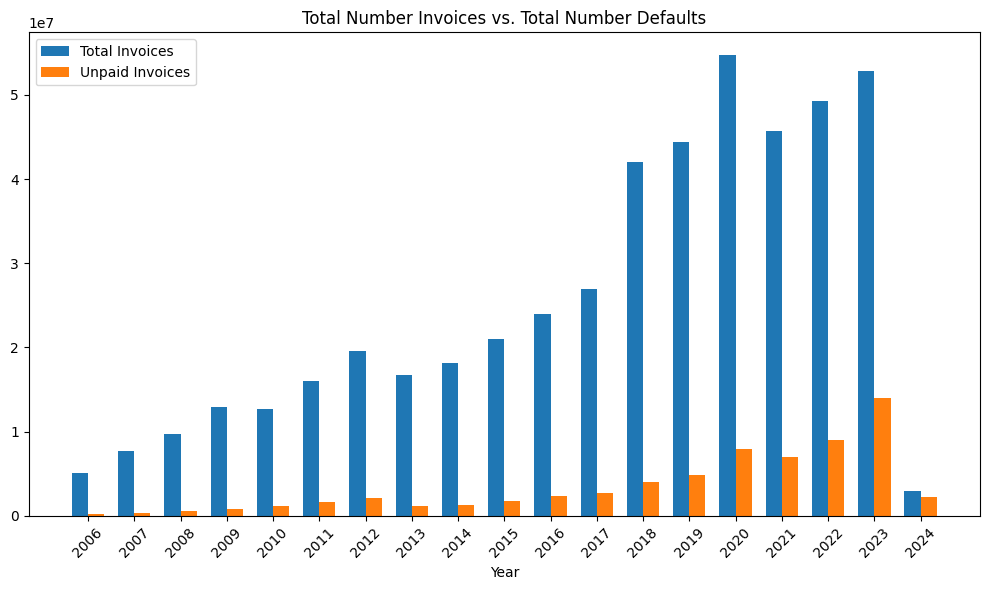

In [ ]:
import matplotlib.pyplot as plt

# Collect the data from Snowflake and sort it
aggregated_data = aggregated_df.sort("YEAR_FECHAEMISION").collect()

# Prepare data
years = [row['YEAR_FECHAEMISION'] for row in aggregated_data]
total_invoices = [row['TOTAL_INVOICES'] for row in aggregated_data]
unpaid_invoices = [row['UNPAID_INVOICES'] for row in aggregated_data]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the figure size
index = range(len(years))
bar_width = 0.35

rects1 = ax.bar(index, total_invoices, bar_width, label='Total Invoices')
rects2 = ax.bar([i + bar_width for i in index], unpaid_invoices, bar_width, label='Unpaid Invoices')

ax.set_xlabel('Year')
ax.set_title('Total Number Invoices vs. Total Number Defaults')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(years, rotation=45)  # Rotate labels to 45 degrees
ax.legend()

plt.tight_layout()  # Adjust layout to make room for label
plt.show()


#By year: difference in Number of invoices vs. Difference in Number of defaults

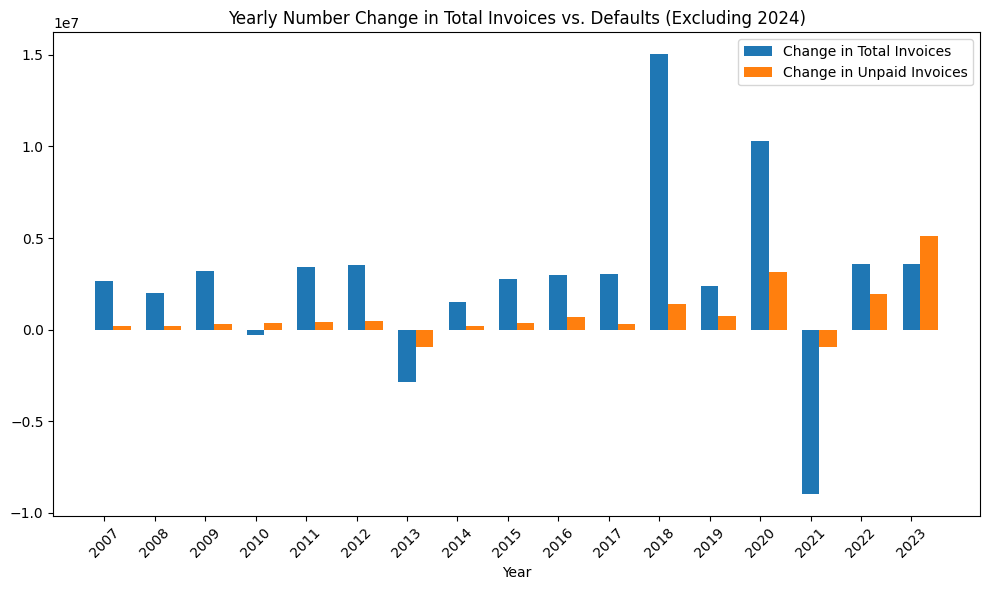

In [ ]:
# Filter out the year 2024 from the aggregated data
filtered_data = [row for row in aggregated_data if row['YEAR_FECHAEMISION'] != 2024]

# Prepare data
years = [row['YEAR_FECHAEMISION'] for row in filtered_data]
total_invoices = [row['TOTAL_INVOICES'] for row in filtered_data]
unpaid_invoices = [row['UNPAID_INVOICES'] for row in filtered_data]

# Calculate differences using numpy.diff without prepending NaN
total_invoices_diff = np.diff(total_invoices)  # Yearly difference in total invoices
unpaid_invoices_diff = np.diff(unpaid_invoices)  # Yearly difference in unpaid invoices
years_diff = years[1:]  # Adjusting years to align with the differences

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
index = range(len(years_diff))  # Adjust index to match years_diff length
bar_width = 0.35

rects1 = ax.bar(index, total_invoices_diff, bar_width, label='Change in Total Invoices')
rects2 = ax.bar([i + bar_width for i in index], unpaid_invoices_diff, bar_width, label='Change in Unpaid Invoices')

ax.set_xlabel('Year')
ax.set_title('Yearly Number Change in Total Invoices vs. Defaults (Excluding 2024)')
ax.set_xticks(index)  # Use the new index
ax.set_xticklabels(years_diff, rotation=45)  # Use years_diff for labels
ax.legend()

plt.tight_layout()
plt.show()


# Yearly change in  number of invoices vs. percent default, excluding 2024

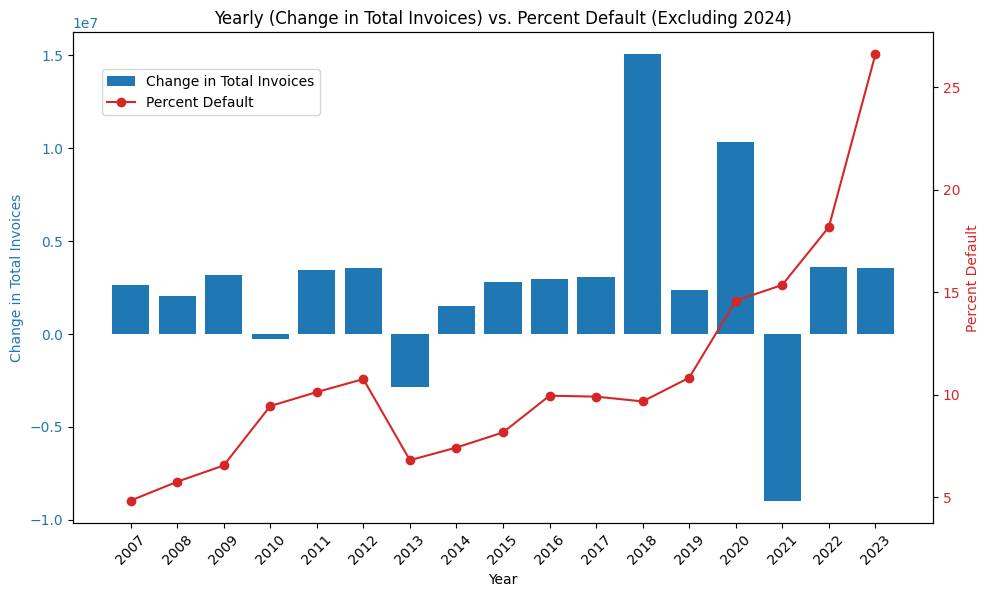

In [ ]:

years = [row['YEAR_FECHAEMISION'] for row in filtered_data]
total_invoices = [row['TOTAL_INVOICES'] for row in filtered_data]
unpaid_invoices = [row['UNPAID_INVOICES'] for row in filtered_data]

# Calculate differences
# Note: We start from the second year since the first year has no previous year to compare with
total_invoices_diff = np.diff(total_invoices)  # Yearly difference in total invoices
years_diff = years[1:]  # Exclude the first year for differences to align years with their differences correctly

# Calculate percent default (unpaid/total) and also start from the second year
percent_default = [(unpaid / total * 100) if total > 0 else 0 for unpaid, total in zip(unpaid_invoices[1:], total_invoices[1:])]

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for differences in total invoices
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Change in Total Invoices', color=color)
ax1.bar(years_diff, total_invoices_diff, color=color, label='Change in Total Invoices')  # Use years_diff
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(years_diff)
ax1.set_xticklabels(years_diff, rotation=45)

# Create second y-axis for percent default
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Percent Default', color=color)
ax2.plot(years_diff, percent_default, color=color, label='Percent Default', marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Yearly (Change in Total Invoices) vs. Percent Default (Excluding 2024)')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()


In [ ]:
# OLS Regression on Yearly change in number of invoices vs. percent default, excluding 2024
# Data preparation, assuming prior filtering and adjustments
years = [row['YEAR_FECHAEMISION'] for row in filtered_data]
total_invoices = [row['TOTAL_INVOICES'] for row in filtered_data]
unpaid_invoices = [row['UNPAID_INVOICES'] for row in filtered_data]

# Calculate differences and percent default, aligning start from the second year
total_invoices_diff = np.diff(total_invoices)  # Yearly difference in total invoices
percent_default = [(unpaid / total * 100) if total > 0 else 0 for unpaid, total in zip(unpaid_invoices[1:], total_invoices[1:])]

# Create a DataFrame for the regression analysis
data = {
    'Change in Total Invoices': total_invoices_diff,
    'Percent Default': percent_default
}
df = pd.DataFrame(data)
# Define the dependent variable (y) and the independent variable (X)
X = df['Change in Total Invoices']  # Independent variable
y = df['Percent Default']  # Dependent variable

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Create the OLS model
model = sm.OLS(y, X)

# Fit the model
results = model.fit()

# Print out the regression statistics
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:        Percent Default   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.066
Method:                 Least Squares   F-statistic:                   0.01325
Date:                Sat, 13 Apr 2024   Prob (F-statistic):              0.910
Time:                        09:28:03   Log-Likelihood:                -52.095
No. Observations:                  17   AIC:                             108.2
Df Residuals:                      15   BIC:                             109.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


# Yearly change in  number of invoices vs. change in percent default, excluding 2024

In [ ]:
import numpy as np

# Assuming the data is already filtered and sorted without the year 2024
years = [row['YEAR_FECHAEMISION'] for row in filtered_data]
total_invoices = [row['TOTAL_INVOICES'] for row in filtered_data]
unpaid_invoices = [row['UNPAID_INVOICES'] for row in filtered_data]

# Calculate differences
# Note: We start from the second year since the first year has no previous year to compare with
total_invoices_diff = np.diff(total_invoices)  # Yearly difference in total invoices
years_diff = years[1:]  # Exclude the first year for differences to align years with their differences correctly

# Calculate percent default (unpaid/total)
percent_default = [(unpaid / total * 100) if total > 0 else 0 for unpaid, total in zip(unpaid_invoices, total_invoices)]
# Calculate differences for percent defaults, also aligning with years correctly
percent_default_diff = np.diff(percent_default)


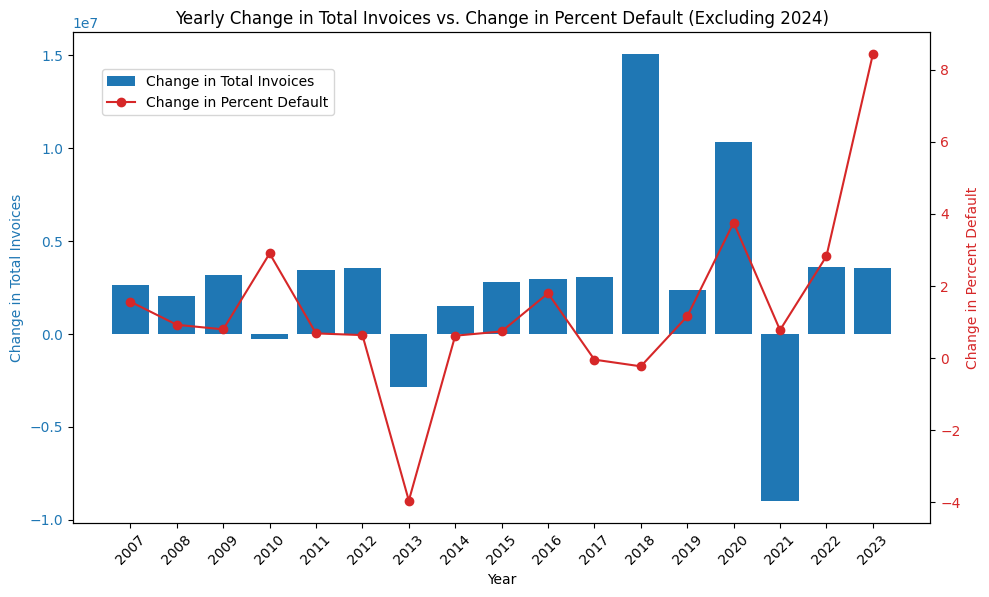

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for differences in total invoices
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Change in Total Invoices', color=color)
ax1.bar(years_diff, total_invoices_diff, color=color, label='Change in Total Invoices')  # Use years_diff
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(years_diff)
ax1.set_xticklabels(years_diff, rotation=45)

# Create second y-axis for percent default difference
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Change in Percent Default', color=color)
ax2.plot(years_diff, percent_default_diff, color=color, label='Change in Percent Default', marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Yearly Change in Total Invoices vs. Change in Percent Default (Excluding 2024)')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()


In [ ]:
# OLS Regression on Change in Number Total Invoices
data = {
    'Change in Number Total Invoices': np.diff(total_invoices),  # Yearly difference in total invoices
    'Change in Percent Default': np.diff(percent_default)  # Yearly difference in percent default
}
df = pd.DataFrame(data)

# Since we're working with changes (differences), the year labels should correspond to the year of the change
df['Year'] = years[1:]  # Use years_diff to label the data properly

# Define the dependent and independent variables
X = df['Change in Total Invoices']  # Independent variable
y = df['Change in Percent Default']  # Dependent variable

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Create the OLS model with variable names included for clarity
model = sm.OLS(y, X)

# Fit the model
results = model.fit()

# Print out the statistics
print(results.summary())


                                OLS Regression Results                               
Dep. Variable:     Change in Percent Default   R-squared:                       0.037
Model:                                   OLS   Adj. R-squared:                 -0.027
Method:                        Least Squares   F-statistic:                    0.5764
Date:                       Sat, 13 Apr 2024   Prob (F-statistic):              0.459
Time:                               09:18:15   Log-Likelihood:                -38.503
No. Observations:                         17   AIC:                             81.01
Df Residuals:                             15   BIC:                             82.67
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
